In [1]:
from utils.misc import *
from train_single.train import Train,Test
from datasets.data_utils import load_dataset
from model_single.Creat_model import creat_model

In [2]:
from torch.backends import cudnn
def fix_seed(seed):
    #seed = 2023
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   

In [3]:
import networkx
import torch
import scipy.sparse as sp
import numpy as np
import os
import random
from munkres import Munkres
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import argparse
import yaml
from torch_geometric.utils.convert import to_networkx
import pynvml

def build_args():
    
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', type=str, default="acm")
    parser.add_argument('--seed', type=int, default=20)
    parser.add_argument('--cuda', type=bool, default=True)
    parser.add_argument('--n_input', type=int, default=None)
    parser.add_argument('--n_z', type=int, default=None)
    parser.add_argument('--freedom_degree', type=float, default=1.0)
    parser.add_argument('--epoch', type=int, default=None)
    parser.add_argument('--shuffle', type=bool, default=True)
    parser.add_argument('--sigma', type=float, default=None)
    parser.add_argument('--loss_n', type=float, default=None)
    parser.add_argument('--loss_w', type=float, default=None)
    parser.add_argument('--loss_s', type=float, default=None)
    parser.add_argument('--loss_a', type=float, default=None)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--acc', type=float, default=-1)
    parser.add_argument('--f1', type=float, default=-1)
    args = parser.parse_args([])
    return args

In [4]:
def pca(adata, use_reps=None, n_comps=10):
    
    """Dimension reduction with PCA algorithm"""
    
    from sklearn.decomposition import PCA
    from scipy.sparse.csc import csc_matrix
    from scipy.sparse.csr import csr_matrix
    pca = PCA(n_components=n_comps)
    if use_reps is not None:
       feat_pca = pca.fit_transform(adata.obsm[use_reps])
    else: 
       if isinstance(adata.X, csc_matrix) or isinstance(adata.X, csr_matrix):
          feat_pca = pca.fit_transform(adata.X.toarray()) 
       else:   
          feat_pca = pca.fit_transform(adata.X)
    
    return feat_pca

def clr_normalize_each_cell(adata, inplace=True):
    
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()
    
    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else np.array(adata.X))
    )
    return adata     

In [5]:
args = build_args()
args = load_configs(args, "config/configs.yml")
# set_random_seed(2024)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

load configs


In [6]:
import scanpy as sc
adata_omics1=sc.read_h5ad("/home/hfzhang/data/空间转录组/merfish-0.14.h5ad")
adata_omics1.obsm['spatial']=adata_omics1.obsm['spatial'].astype(float)

In [7]:
adata_omics1

AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'region', 'label'
    obsm: 'spatial'

In [8]:

adata_omics1 = clr_normalize_each_cell(adata_omics1)
sc.pp.scale(adata_omics1)
adata_omics1.obsm['feat'] = pca(adata_omics1, n_comps=adata_omics1.n_vars-1)

/tmp/ipykernel_32588/529664883.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_32588/529664883.py:7: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix


In [9]:
from utils.preprocess import *
from utils.utils import *

2025-03-20 15:30:11.771638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 15:30:11.957215: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 15:30:12.584414: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:
2025-03-20 15:30:12.584514: W tensorflow/compiler/xla/stream_executor/p

In [10]:
import numpy as np
from scipy.sparse import coo_matrix

def transform_adjacent_matrix(adjacent):
    n_spot = max(adjacent['x'].max(), adjacent['y'].max()) + 1
    
    # Ensure no indices exceed the matrix dimensions
    mask = (adjacent['x'] < n_spot) & (adjacent['y'] < n_spot)
    adjacent['x'] = adjacent['x'][mask]
    adjacent['y'] = adjacent['y'][mask]
    adjacent['value'] = adjacent['value'][mask]
    
    adj = coo_matrix((adjacent['value'], (adjacent['x'], adjacent['y'])), shape=(n_spot, n_spot))
    return adj

In [11]:
def create_adj(adata):
    cell_position_omics1 = adata.obsm['spatial']
    adj_omics1 = construct_graph_by_coordinate(cell_position_omics1, n_neighbors=3)
    adata.uns['adj_spatial'] = adj_omics1
    adj_spatial_omics1 = adata.uns['adj_spatial']
    adj_spatial_omics1 = transform_adjacent_matrix(adj_spatial_omics1)
    adj_spatial_omics1 = adj_spatial_omics1.toarray()
    adj_spatial_omics1 = adj_spatial_omics1 + adj_spatial_omics1.T
    adj_spatial_omics1 = np.where(adj_spatial_omics1>1, 1, adj_spatial_omics1)
    adj = preprocess_graph(adj_spatial_omics1)
    return adj

In [12]:
label = adata_omics1.obs['region'].astype(str) #先全部转成string  
label[pd.isna(label)] = "nan"  # 将缺失值替换为 "NA"，前提是你用了pandas
# label=adata_omics1.obs['ground_truth'].values
classes, label = np.unique(label, return_inverse=True)
classes = classes.tolist()

In [13]:
device='cuda:0'
args.n_input=adata_omics1.n_vars
# args.n_input1=adata_omics2.n_vars-1
args.n_clusters=len(classes)
args.n_clusters
args.Type='Stereo-CITE-seq'
args.n_clusters=len(classes)

In [24]:
random_seed=2024
args.random_seed=random_seed
fix_seed(random_seed)

In [25]:
args.tool='kmeans'
args.sigma=0.4
args.lr=0.01
args.loss_n=0.5
args.loss_a=0.5

In [26]:
# adata_omics2_train,adata_omics2_test =adata_omics2, adata_omics2
args.n_clusters1=len(set(label))
args.n_clusters2=len(set(label))
adj_train=create_adj(adata_omics1)
adj_train = adj_train.to(device)
features_omics1_train = torch.FloatTensor(adata_omics1.X.copy()).to(device)
# features_omics1_train = torch.FloatTensor(adata_omics1.obsm['feat'].copy()).to(device)
# features_omics1_test = torch.FloatTensor(adata_omics1_test.obsm['feat'].copy()).to(device)
# features_omics2_test = torch.FloatTensor(adata_omics2_test.obsm['feat'].copy()).to(device)

model = creat_model('spamgcn', args).to(device)
# model=preTrain(200, model, features_omics1_train,features_omics2_train, adj_train, label_train, device, args)
model=Train(100, model,adata_omics1, features_omics1_train, adj_train, label, device, args)
nmi, ari, ami, homogeneity, completeness, v_measure=Test(model,adata_omics1,features_omics1_train,adj_train,label,device,args,'leiden')

tool: kmeans
  9 loss: 1.3304859399795532
Epoch_  9 , nmi 0.1689 , ari 0.0819 , ami 0.1672 , homogeneity 0.1781 , completeness 0.1607 , v_measure 0.1689
 19 loss: 5.251049995422363
Epoch_ 19 , nmi 0.3445 , ari 0.1796 , ami 0.3431 , homogeneity 0.3604 , completeness 0.3299 , v_measure 0.3445
 29 loss: 5.156411647796631
Epoch_ 29 , nmi 0.4880 , ari 0.3697 , ami 0.4869 , homogeneity 0.5066 , completeness 0.4708 , v_measure 0.4880
 39 loss: 5.078149318695068
Epoch_ 39 , nmi 0.5170 , ari 0.3944 , ami 0.5159 , homogeneity 0.5341 , completeness 0.5009 , v_measure 0.5170
 49 loss: 5.033325672149658
Epoch_ 49 , nmi 0.5266 , ari 0.3572 , ami 0.5256 , homogeneity 0.5470 , completeness 0.5077 , v_measure 0.5266
 59 loss: 4.9918904304504395
Epoch_ 59 , nmi 0.4939 , ari 0.3692 , ami 0.4927 , homogeneity 0.5107 , completeness 0.4781 , v_measure 0.4939
 69 loss: 4.9776506423950195
Epoch_ 69 , nmi 0.5170 , ari 0.3376 , ami 0.5160 , homogeneity 0.5354 , completeness 0.4999 , v_measure 0.5170
 79 loss: 4

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


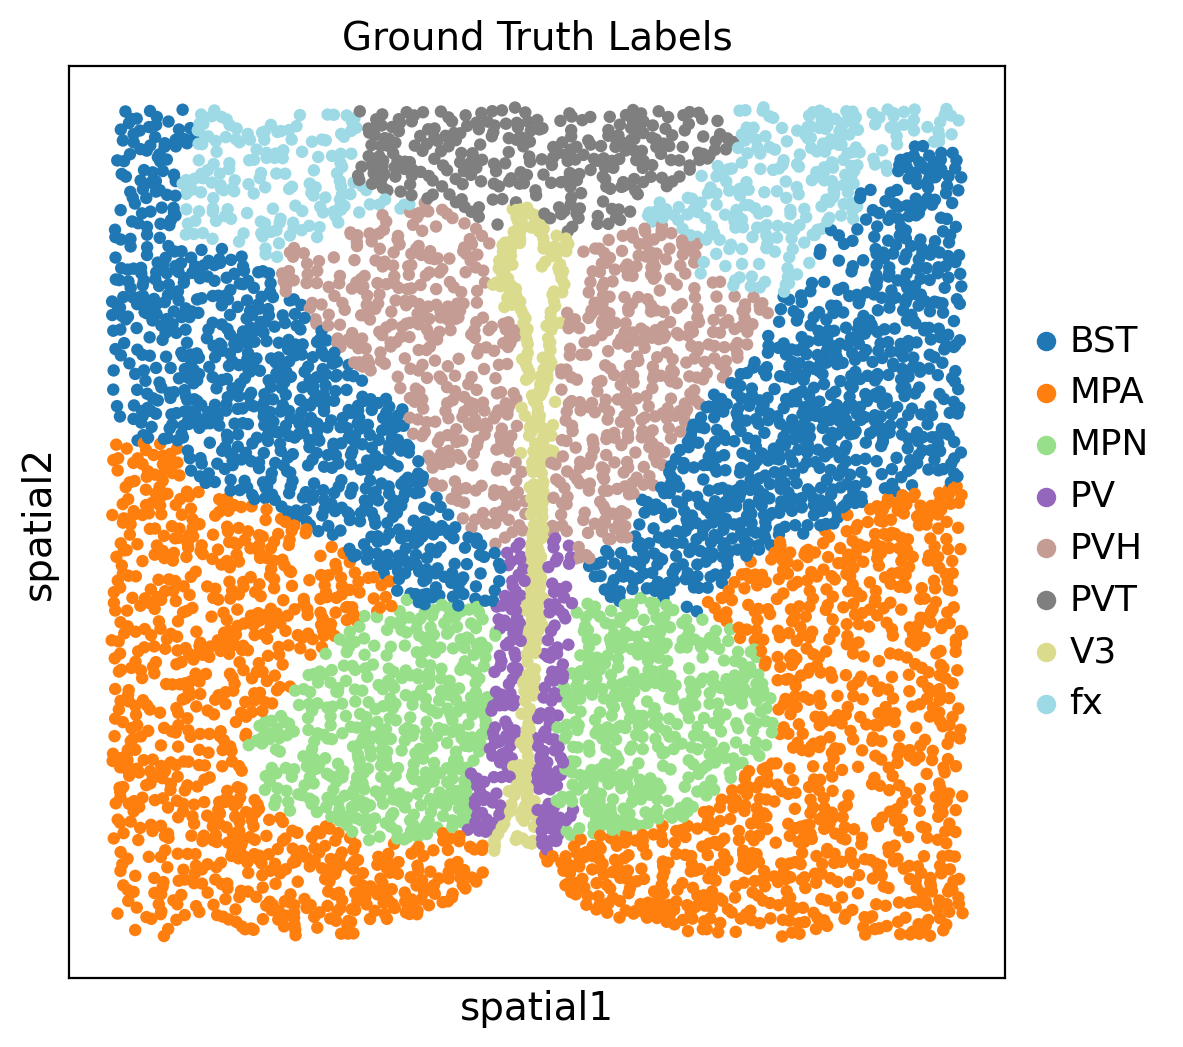

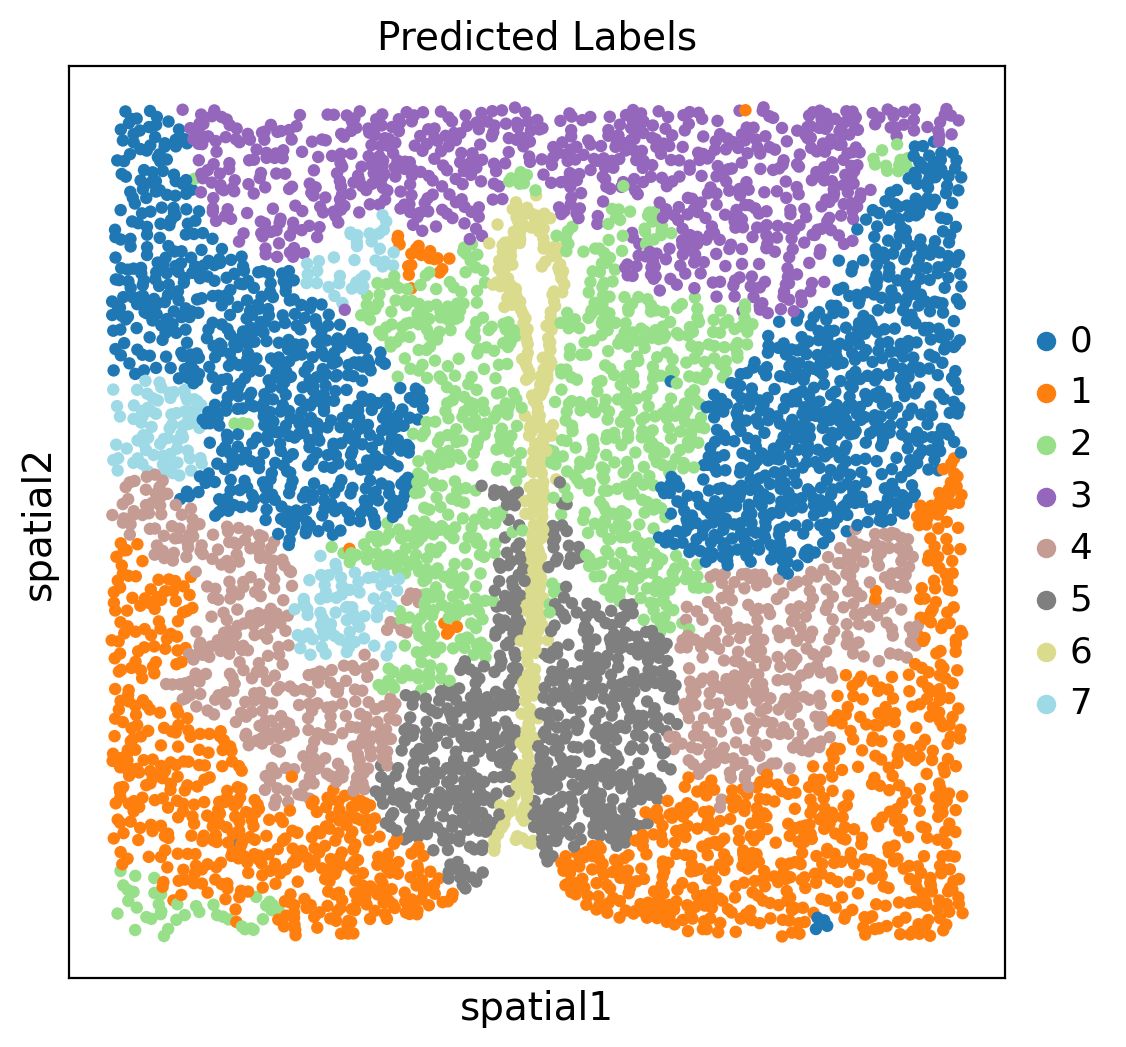

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

# 假设你已经有一个 AnnData 对象 adata_omics1_train
# adata_omics1_train 包含降维后的嵌入（例如 UMAP 或 t-SNE）和 obs 中的 ground_truth 和 pred 列

# 1. 检查 AnnData 对象
# print(adata_omics1_train)

# 2. 设置绘图参数
sc.set_figure_params(figsize=(6, 6), dpi=100)

# 3. 绘制真实标签的嵌入图
sc.pl.embedding(
    adata_omics1,
    basis='spatial',  # 使用空间坐标
    color='region',  # 使用 obs 中的 ground_truth 列作为颜色
    title='Ground Truth Labels',
    palette='tab20',  # 使用高对比度的颜色映射
    size=80,  # 调整点的大小，值越大，点越大
    show=False,  # 不立即显示，方便保存或调整
)

# 4. 绘制预测标签的嵌入图
sc.pl.embedding(
    adata_omics1,
    basis='spatial',  # 使用空间坐标
    color='pred',  # 使用 obs 中的 pred 列作为颜色
    title='Predicted Labels',
    palette='tab20',  # 使用高对比度的颜色映射
    size=80,  # 调整点的大小，值越大，点越大
    show=False,  # 不立即显示，方便保存或调整
)

# 5. 显示图像
plt.show()